In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import sys
import os
%run ../externals/deep_pnml/notebooks/plot_functions.ipynb
sys.path.insert(0, '../src/')


output_path =  ../output/figures
plt = single_column_plt_params(plt)
plt = double_column_plt_params(plt)


In [2]:
from data_linear_regression_utilities import DataParameters, DataPolynomial
plt = double_column_plt_params(plt)

In [3]:
def calculate_capacity(phi: np.ndarray,phi_test: np.ndarray, lamb: float = 0.0) -> float:
    """
    Calculate the capacity of the mixture learner.
    :param phi: the feature matrix (train+test).
    :param lamb: regularization term value.
    :return: capacity.
    """
    # Assuming the test features are last
    phi_phi_t = np.matmul(phi, phi.transpose())
    phi_phi_t_inv = np.linalg.pinv(phi_phi_t + lamb * np.eye(phi_phi_t.shape[0], phi_phi_t.shape[1]))

    return float(np.log( 1 + phi_test.T.dot(phi_phi_t_inv).dot(phi_test)))

In [4]:
data_params_dict= {
        "x_train": [-0.7, -0.6, 0.05, 0.1, 0.25, 0.3, 0.35, 0.5, 0.55, 0.6],
        "y_train": [-0.1, -0.2, -2.0, -1.0, -0.5, -0.3, 0.1, 0.5, 0.2, 0.1],
        "num_points": 10,
        "poly_degree": [3,6,10],
        "lamb": 1e-6,
        "is_random": False,
        "interval_min": -1.0,
        "interval_max": 1.0
}

In [5]:
data_params = DataParameters()
for key, value in data_params_dict.items():
    setattr(data_params, key, value)
data_h = DataPolynomial(data_params)

ploy_degree_list = [3,6,9]
x_test_array = np.arange(data_params.interval_min,data_params.interval_max,0.01)

In [6]:
result_capacity_dict = {}
result_mean_predictor_dict = {}
for poly_degree in data_params.poly_degree:
    
     # Create training set
    data_h.create_train(poly_degree)
    x_train, y_train = data_h.get_data_points_as_list()
    data_h.create_train(poly_degree)
    
    # Iterate on test points and calculate capacity
    capacity_list = []
    prediction_list = []
    for x_test in x_test_array:
        phi_test = data_h.convert_point_to_features(x_test, poly_degree)
        phi = data_h.add_test_to_train(data_h.phi_train, phi_test)
    
        # Calculate the capacity
        capacity = calculate_capacity(phi,phi_test, data_params.lamb)
        capacity_list.append(capacity)

        # Predict
        theta_erm = data_h.fit_least_squares_estimator(data_h.phi_train,
                                                        data_h.get_labels_array(),
                                                        data_params.lamb)
        prediction = float(theta_erm.T.dot(phi_test)) 
        prediction_list.append(prediction)
    
    result_capacity_dict[str(poly_degree)] = capacity_list
    result_mean_predictor_dict[str(poly_degree)] = prediction_list
 

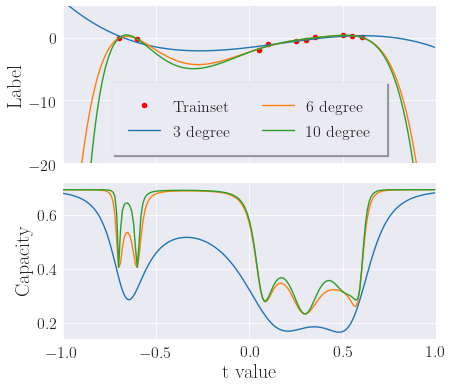

In [8]:
w, h = plt.rcParams.get('figure.figsize')
fig, axs = plt.subplots(2, 1, facecolor='w', figsize=(w, 1.25*h), sharex=True)


axs[0].plot(x_train, y_train, 'or', label='Trainset')
for poly_degree in data_params.poly_degree:

    # Mean of the mixture predictor
    prediction = result_mean_predictor_dict[str(poly_degree)]
    ax = axs[0]
    ax.plot(x_test_array, prediction, label='{} degree'.format(poly_degree))
    ax.set_ylabel('Label')
    ax.set_ylim(-10, 10)

    # Capacity the mixture predictor
    capacity_list = result_capacity_dict[str(poly_degree)]
    ax = axs[1]
    ax.plot(x_test_array, capacity_list)

axs[0].set_ylim(-20, 5)
axs[0].set_ylabel('Label')
axs[1].set_ylabel('Capacity')
axs[1].set_xlabel('t value')


axs[0].legend(loc=8, ncol=2, fancybox=False,
              frameon=True, shadow=True, borderpad=1)
plt.xlim(-1, 1)
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'figure_mixture_linear_regression.pdf'), dpi=300, bbox_inches=plt.tight_layout())
plt.show()
